**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS5489 - Tutorial 5
## Predicting Bike Sharing Usage

In this tutorial you will train a regression function to predict the number people using bike sharing in each day.

First we need to initialize Python.  Run the below cell.

In [34]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)

IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats

/var/folders/sm/c6fy0mvx1y70_0_18nmdlm680000gn/T/ipykernel_1126/4148477773.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("svg")


## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `Bike-Sharing-Dataset.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [35]:
# read the data
filename = 'Bike-Sharing-Dataset/day.csv'
df = pd.read_csv(filename)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Here are the columns in the dataset. The last 3 columns are the counts for the day.

In [36]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

The first two columns are the instance number and date, which aren't useful, so we will remove them.

In [37]:
# remove first 2 columns
df.drop(columns=['instant', 'dteday'], inplace=True)

Next we will examine the distribution of the features.

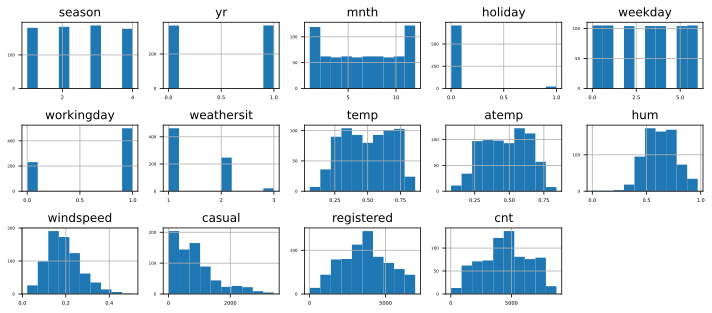

In [38]:
# show the feature distributions
foo = df.hist(layout=(14,5), figsize=(10,20), xlabelsize=5, ylabelsize=4)
plt.tight_layout()

And here are some simple statistics of the features.

In [39]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


You may notice that a few of the features are discrete values, such as `season`, `mnth`, `weekday`, and `weathersit`.  If we directly use the month feature, it may not make too much sense since adding/subtracting/multipllying 2 month numbers doesn't really mean anything related to the output. Instead, it is important which month it is.

Thus, we will convert these features into one-hot-encodings.  The original discrete features are removed, and the new features are appended to the end of the table.

In [40]:
# use pandas to create one-hot-encodings of a few colummns
dfd = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'])
dfd

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,...,0,0,0,0,1,0,0,0,1,0
727,1,0,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,...,0,0,0,0,0,1,0,0,1,0
728,1,0,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,...,0,0,0,0,0,0,1,0,1,0
729,1,0,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,...,1,0,0,0,0,0,0,1,0,0


Now we extract the data for running our regression algorithm. First we remove the counts to get the input features X.

In [41]:
# extract the features
dfX = dfd.drop(columns=['casual', 'registered', 'cnt'])
dataX = array(dfX)
dataX.shape

(731, 33)

In [42]:
# get the feature names
featnames = [x.strip() for x in dfX.columns]
print(featnames)

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']


Next we use the total count as the target Y.

In [43]:
# get the target count
dataY = array(dfd['cnt'])
dataY.shape

(731,)

Finally, we extract the year number, which we will use for setting up the training/testing data later.

In [44]:
# get the year number (used for splitting the data into training/testing)
dataYear = array(dfd['yr'])
dataYear.shape

(731,)

Here is an example input/output for our problem.

In [45]:
print(featnames)

print("--- example features---")
print(dataX[0])
print("--- example target count")
print(dataY[0])

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']
--- example features---
[0.       0.       0.       0.344167 0.363625 0.805833 0.160446 1.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       1.       0.       1.
 0.      ]
--- example target count
985


Now we separate the data into training and testing sets.  Since our data is collected over time, it is better to separate the training and test data so that they don't overlap in time. This way, we can ensure that our method generalizes to newly collected data.

We will use the first year for training, and the second year for testing.

In [46]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
# use 2nd year as testing data
testX  = dataX[dataYear==1]
testY  = dataY[dataYear==1]

print(trainX.shape)
print(testX.shape)

(365, 33)
(366, 33)


Note that the input features are already normalized between 0 and 1 (or are binary values), so we don't need to perform feature normalization.

### Dummy regressor
We next test a "dummy" regressor that simply predicts the mean or median output value.  These are useful to evaluate the regression methods to see how much better they are than simply predicting the same value.

In [47]:
# dummy regressors that predict constant values
dummy_mean = dummy.DummyRegressor(strategy='mean')
dummy_mean.fit(trainX, trainY)
dummy_med  = dummy.DummyRegressor(strategy='median')
dummy_med.fit(trainX, trainY)

DummyRegressor(strategy='median')

Next we evaluate the regressor using MSE and MAE.

In [48]:
# function to evaluate root mean squared error (MSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [49]:
# place to store our regression results
trainerr={}; testerr={}

trainerr['dummy_mean'] = eval_predict(trainY, dummy_mean.predict(trainX))
testerr['dummy_mean']  = eval_predict(testY, dummy_mean.predict(testX))
trainerr['dummy_med']  = eval_predict(trainY, dummy_med.predict(trainX))
testerr['dummy_med']   = eval_predict(testY, dummy_med.predict(testX))

print("dummy-mean: train (RMSE,MAE)=", trainerr['dummy_mean'] )
print("dummy-mean: test  (RMSE,MAE)=", testerr['dummy_mean']  )
print("dummy-med:  train (RMSE,MAE)=", trainerr['dummy_med']  )
print("dummy-med:  test  (RMSE,MAE)=", testerr['dummy_med']   )

dummy-mean: train (RMSE,MAE)= (1376.8636667749531, 1197.7539801088385)
dummy-mean: test  (RMSE,MAE)= (2829.3083242385123, 2488.6733587843405)
dummy-med:  train (RMSE,MAE)= (1416.8517338156587, 1172.8849315068494)
dummy-med:  test  (RMSE,MAE)= (2578.749205425156, 2260.841530054645)


Finally, we can visualize the quality of the prediction result by using a scatter plot.  Since we are using a "dummy" predictor, the x-value predictions are constant.  The red line shows the ideal regressor where all the predictions are equal to the true values.

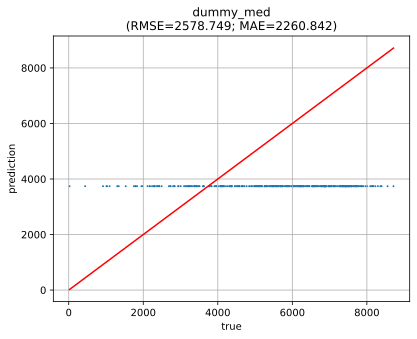

In [50]:
plot_scatter(testY, dummy_med.predict(testX), 'dummy_med')

## 2. Prediction with Linear Regression

First we will look at predicting the count using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [51]:
### INSERT YOUR CODE HERE

In [52]:
### INSERT YOUR CODE HERE
clfs = {}
ols = linear_model.LinearRegression()
ols.fit(trainX, trainY)

clfs['ols'] = ols

train RMSE,MAE: (552.8169381660512, 413.93150684931504)


In [53]:
alphas = logspace(-5,15,30)

rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainX, trainY)

print("best alpha: ", rr.alpha_)

trainerr['rr'] = eval_predict(trainY, rr.predict(trainX))
testerr['rr']  = eval_predict(testY,  rr.predict(testX))

print("train error: ", trainerr['rr'])
print("test error : ", testerr['rr'])
clfs['rr'] = rr

best alpha:  0.1373823795883264
train error:  (549.8603078177017, 407.32198357077857)
test error :  (2304.7279932583015, 2127.891327589533)


Compare the two models using the RMSE and MAE between the predictions and the true values.  Below is  code that will calculate evaluation for the training and test sets.

In [54]:
# ols is the linear regression model
trainerr['ols'] = eval_predict(trainY, ols.predict(trainX))
testerr['ols']  = eval_predict(testY, ols.predict(testX))
print("OLS: train MSE,MAE =", trainerr['ols'])
print("OLS: test  MSE,MAE =", testerr['ols'])

# rr is the ridge regression model
trainerr['rr'] = eval_predict(trainY, rr.predict(trainX))
testerr['rr']  = eval_predict(testY, rr.predict(testX))
print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])

OLS: train MSE,MAE = (552.8169381660512, 413.93150684931504)
OLS: test  MSE,MAE = (4089569317362.1914, 4089569317362.1914)
RR: train MSE,MAE = (549.8603078177017, 407.32198357077857)
RR: test  MSE,MAE = (2304.7279932583015, 2127.891327589533)


Which model has better prediction ability on the test set? Why?
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- RR performs slightly better.  Regularization works slightly better.

Finally, we look at the scatter plot for ridge-regression.

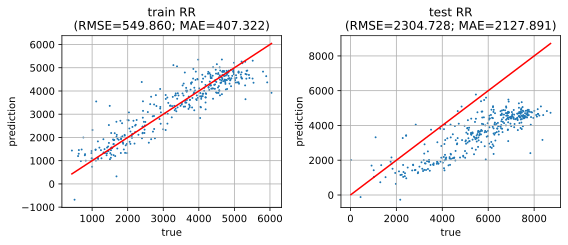

In [22]:
# rr is the ridge regression model
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rr.predict(trainX), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY, rr.predict(testX), "test RR")
plt.tight_layout()

Do you notice anything interesting about the test predictions?  We'll see how to solve this problem later.

- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- on the test set, the predictions are always underpredicting the true values. There seems to be some bias in the test set.

# 3. Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [23]:
### INSERT YOUR CODE HERE

In [24]:
### INSERT YOUR CODE HERE
las = linear_model.LassoCV(max_iter=5000)
las.fit(trainX, trainY)

trainerr['lasso'] = eval_predict(trainY, las.predict(trainX))
testerr['lasso']  = eval_predict(testY, las.predict(testX))
print("LASSO train: ", trainerr['lasso'])
print("LASSO test:  ", testerr['lasso'])
clfs['lasso'] = las

LASSO train:  (559.3462532061881, 419.142788002057)
LASSO test:   (2323.146373590926, 2139.8630951547743)


Examine the LASSO coefficients by sorting them in descending order.

In [25]:
# las is the trained LASSO model
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))
print("bias = ", las.intercept_)

weight : feature description
 3017.218 : temp
-1337.871 : weathersit_3
-1130.775 : windspeed
-1008.439 : season_1
-734.189 : hum
 732.636 : mnth_5
 560.949 : mnth_6
-419.477 : mnth_1
 417.083 : mnth_9
 372.581 : weathersit_1
 348.616 : mnth_10
-253.677 : mnth_2
-232.665 : season_2
 208.324 : season_4
-200.799 : mnth_3
-169.150 : holiday
 82.590 : weekday_6
 62.870 : workingday
 37.365 : weekday_5
 36.897 : season_3
 23.156 : weekday_2
-17.123 : mnth_7
-9.574 : weekday_0
-0.000 : weekday_1
 0.000 : mnth_4
-0.000 : weekday_3
-0.000 : weathersit_2
-0.000 : weekday_4
 0.000 : mnth_8
 0.000 : atemp
-0.000 : mnth_11
-0.000 : mnth_12
 0.000 : yr
bias =  2541.379375849472


_Which features have largest affect on the predicted bike share count, and what is the interpretation?_

Note that the features are normalized between 0 and 1 (or are binary values), so the weights corresponding to increase/decrease of bike count.  The bias term corresponds to the typical number of bikes used, which is modified based on the features.
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
  - higher temperature has the positive impact - higher temperature gives much higher bike count.
  - light snowing/raining (`weathersit_3`), windspeed, winter season, and humidity have the largest negative impact on bike count.
  - nice weather (`weathersit_1`) has moderate posistive impact.
  - May, June, September, October have moderate positive impact on bike count. These are all moderate wheather months.
  - January, Feb, March, and July have moderate negative impact. These are all cold or hot weather months.
  - Tuesdays, Friday and Saturday and workdays in general see a small increase, while Sunday sees a small decrease.

Now try feature selection using OMP.  You can try the top 10 features.

In [26]:
### INSERT YOUR CODE HERE

In [27]:
### INSERT YOUR CODE HERE
omp_train_mse = []
omp_test_mse = []
omp_train_mae = []
omp_test_mae = []
for n in range(1,11):
    omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=n)
    omp.fit(trainX, trainY)
    a,b = eval_predict(trainY, omp.predict(trainX))
    c,d = eval_predict(testY, omp.predict(testX))
    
    omp_train_mse.append(a)
    omp_test_mse.append(c)
    omp_train_mae.append(b)
    omp_test_mae.append(d)
    

Text(0.5, 0, 'n')

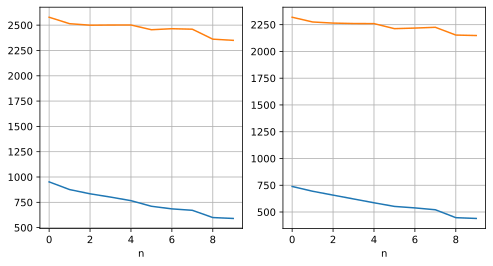

In [28]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(omp_train_mse, label='train MSE')
plt.plot(omp_test_mse, label='test MSE')
plt.grid(True)
plt.xlabel('n')
plt.subplot(1,2,2)
plt.plot(omp_train_mae, label='train MAE')
plt.plot(omp_test_mae, label='test MAE')
plt.grid(True)
plt.xlabel('n')


In [29]:
### INSERT YOUR CODE HERE
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(trainX, trainY)

trainerr['omp'] = eval_predict(trainY, omp.predict(trainX))
testerr['omp']  = eval_predict(testY, omp.predict(testX))
print("OMP train: ", trainerr['omp'])
print("OMP test:  ", testerr['omp'])
clfs['omp'] = omp

OMP train:  (590.5936331958195, 439.7448312112193)
OMP test:   (2349.9456165230654, 2148.4320044373485)


In [30]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(omp.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(omp.coef_[i], featnames[i]))

weight : feature description
 3214.272 : temp
 2036.561 : weathersit_1
 1544.453 : weathersit_2
 855.331 : mnth_5
-780.259 : season_1
 739.020 : season_4
 718.328 : mnth_6
 412.039 : mnth_9
 372.515 : season_3
-212.365 : mnth_1
 0.000 : workingday
 0.000 : atemp
 0.000 : hum
 0.000 : windspeed
 0.000 : mnth_3
 0.000 : season_2
 0.000 : mnth_2
 0.000 : holiday
 0.000 : weathersit_3
 0.000 : mnth_4
 0.000 : mnth_7
 0.000 : mnth_8
 0.000 : mnth_10
 0.000 : mnth_11
 0.000 : mnth_12
 0.000 : weekday_0
 0.000 : weekday_1
 0.000 : weekday_2
 0.000 : weekday_3
 0.000 : weekday_4
 0.000 : weekday_5
 0.000 : weekday_6
 0.000 : yr


Do you get similar selected features? Why or why not?
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
  - the feature are different.
  - feeling temperature has the largest positive impact.
  - weather related measurements (windspeed, light rain/snow, humidity, misty) have the largest negative impact.
  - Winter season has a negative impact, while Fall season, may, June, and September have positive impacts.

# 4. Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters. 

In [31]:
### INSERT YOUR CODE HERE

In [32]:
### INSERT YOUR CODE HERE

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# setup a bunch of regressors to train
allexps = [
    {'name': 'dummy-mean',
     'clf': dummy.DummyRegressor(strategy='mean'),
    },
    {'name': 'dummy-med', 
     'clf': dummy.DummyRegressor(strategy='median'),
    },
    {'name': 'ols',
     'clf': linear_model.LinearRegression(),
    },
    {'name':'rr',
     'clf': linear_model.RidgeCV(alphas=alphas, cv=5),
    },
    {'name': 'lasso',
     'clf': linear_model.LassoCV(max_iter=5000),
    },

    #{'name': 'gpr',
    # 'clf': GaussianProcessRegressor(normalize_y=True, random_state=5489),
    # 'params': {'kernel': [   RBF()+WhiteKernel(),
    #                          DotProduct()**2+WhiteKernel(),
    #                          DotProduct()**3+WhiteKernel(),
    #                          RBF()+DotProduct()+WhiteKernel(),
    #                          RBF()+RBF(length_scale=5.0)+WhiteKernel(),
    #           ]},
    #},    
    {'name': 'rf',
     'clf': ensemble.RandomForestRegressor(random_state=4487, n_estimators=100),
     'params': {'max_depth': array([1, 2, 3, 4, 5, 10, 15])}
    }, 
    {'name': 'svr-poly',
     'clf': svm.SVR(kernel='poly'),
     'params':  {'C': logspace(-3,0,5), 'degree': [1,2], 'epsilon': logspace(-2,2,5)}
    }, 
    {'name': 'xgb',
     'paramsampler': {    
        "colsample_bytree": stats.uniform(0.7, 0.3),  # default=1
        "gamma":            stats.uniform(0, 0.5),    # default=0
        "max_depth":        stats.randint(2, 6),      # default=6
        "subsample":        stats.uniform(0.6, 0.4),  # default=1
        "learning_rate":    stats.uniform(.001,1),    # default=1 (could also use loguniform)
        "n_estimators":     stats.randint(10, 1000),
      },
    'clf': xgb.XGBRegressor(objective="reg:squarederror", random_state=4487) },
]


In [56]:
# function to train all regressors
def train_all(clfs, allexps, trainX, trainY, testX, testY, trainerr, testerr):
    for i,ex in enumerate(allexps):
        myname = ex['name']
        print("=== " + myname + " ==================")
        if myname in clfs:
            print("SKIP")
        else:
            # GPR with kernel selection based on marginal likelhiood
            if (ex['clf'].__class__.__name__ == "GaussianProcessRegressor") and ('params' in ex):
                tmp = []
                tmpml = []
                for k in ex['params']['kernel']:
                    myclf = clone(ex['clf'])
                    myclf.set_params(**{'kernel': k})
                    tmp.append(myclf.fit(trainX, trainY))
                    tmpml.append(myclf.log_marginal_likelihood_value_)
                print(tmpml)
                i = argmax(tmpml)
                print("best model {}: k={}".format(i, tmp[i].kernel_))
                clfs[myname] = tmp[i]
                
            # train using GridSearchCV
            elif 'params' in ex:
                clfs[myname] = model_selection.GridSearchCV(ex['clf'], ex['params'], 
                                scoring='neg_mean_squared_error', cv=5, verbose=True, n_jobs=6)
                clfs[myname].fit(trainX, trainY)

                print(clfs[myname].best_score_)
                print(clfs[myname].best_params_)

            # train with RandomizedSearchCV
            elif 'paramsampler' in ex:            
                clfs[myname] = model_selection.RandomizedSearchCV(ex['clf'], 
                                    param_distributions=ex['paramsampler'], 
                                    random_state=4487, n_iter=100, cv=5, 
                                    verbose=1, n_jobs=6)
                clfs[myname].fit(trainX, trainY)

            # normal training
            else:
                clfs[myname] = clone(ex['clf'])
                clfs[myname].fit(trainX, trainY)

            # compute errors
            trainerr[myname] = eval_predict(trainY, clfs[myname].predict(trainX))
            testerr[myname]  = eval_predict(testY, clfs[myname].predict(testX))

            print("train error:", trainerr[myname])
            print("test error :", testerr[myname])

In [57]:
# run training
train_all(clfs, allexps, trainX, trainY, testX, testY, trainerr, testerr)

=== dummy-mean ==================
train error: (1376.8636667749531, 1197.7539801088385)
test error : (2829.3083242385123, 2488.6733587843405)
=== dummy-med ==================
train error: (1416.8517338156587, 1172.8849315068494)
test error : (2578.749205425156, 2260.841530054645)
=== ols ==================
SKIP
=== rr ==================
SKIP
=== lasso ==================
train error: (559.3462532061881, 419.142788002057)
test error : (2323.146373590926, 2139.8630951547743)
=== rf ==================
Fitting 5 folds for each of 7 candidates, totalling 35 fits
-645532.6077241575
{'max_depth': 10}
train error: (230.97463200663842, 169.0549297248979)
test error : (2209.0110833180024, 2052.3874518731827)
=== svr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits
-2693721.856742471
{'C': 1.0, 'degree': 2, 'epsilon': 100.0}
train error: (1391.2676536990532, 1152.0989306800145)
test error : (2574.626161453529, 2258.4996923527465)
=== xgb ==================
Fitt

In [58]:
testerr

{'dummy_mean': (2829.3083242385123, 2488.6733587843405),
 'dummy_med': (2578.749205425156, 2260.841530054645),
 'ols': (4089569317362.1914, 4089569317362.1914),
 'rr': (2304.7279932583015, 2127.891327589533),
 'dummy-mean': (2829.3083242385123, 2488.6733587843405),
 'dummy-med': (2578.749205425156, 2260.841530054645),
 'lasso': (2323.146373590926, 2139.8630951547743),
 'rf': (2209.0110833180024, 2052.3874518731827),
 'svr-poly': (2574.626161453529, 2258.4996923527465),
 'xgb': (2191.0448722938695, 2040.4584654094092)}

In [59]:
# extract the test errors
methnames = [k for k in testerr]
methmse   = [testerr[k][0] for k in testerr]

In [60]:
# select the best method
i = argmin(methmse)
minmse = methmse[i]
minmeth = methnames[i]
print(minmeth, minmse)
bestr = clfs[minmeth]

xgb 2191.0448722938695


Make a scatter plot of the best regressor. Call it `bestr`.

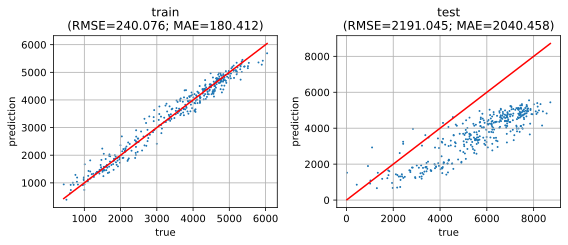

In [61]:
# scatter plot of the best regressor (bestr)
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, bestr.predict(trainX), "train")
plt.subplot(1,2,2)
plot_scatter(testY, bestr.predict(testX), "test")
plt.tight_layout()

_Which regression method performs the best? Why do you think so?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- XGboost is the best.
- random forest also does well.

# 5. Test set bias

In your scatter plot above, you may have noticed that the regressor is almost always under-predicting the count (the points are usually below the red line). This suggests that there is some bias in the test set.

Let's look at the plot of the count over time.  The left side is the training data (1st year), and the right side is the testing data (2nd year)

In [ ]:
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

Interestingly, it looks like bike sharing became more popular in the 2nd year, so the overall counts are higher (but the seasonal trend looks the same).

Let's assume that we noticed this upward trend in the first 3 months of the year, and collected the data for training.  We will then use the remaining part of the 2nd year for testing.

In [63]:
# get indices for month 1 to month 3
print(featnames[11], featnames[12], featnames[13])
inds = (testX[:,11].ravel()==1) + (testX[:,12].ravel()==1) + (testX[:,13].ravel()==1)

# new training data from 2nd year (months 1-3)
trainX2 = testX[inds]
trainY2  = testY[inds]
# new testing data from 2nd year (months 4-12)
testX2  = testX[logical_not(inds)]
testY2   = testY[logical_not(inds)]
print(trainX2.shape)
print(testX2.shape)

mnth_1 mnth_2 mnth_3
(91, 33)
(275, 33)


There are several approaches for using the new data:
1. use the new data to train the regressor, and ignore the old data.
2. append the new data with the old data and train a regressor.  Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.
3. use the new data to train a regressor on the residual error of the old regressor.  The residual error is the difference between the predicted count and true count on the new training data.

Using **one selected** regression method, try each of the approaches above to use the new data. You should compare the 3 approaches with the regressor trained on the original data and tested on the new test set (`testY2`).

In [64]:
# append new data with old data
trainY2_append = concatenate((trainY, trainY2), axis=0)
trainX2_append = concatenate((trainX, trainX2), axis=0)
print(trainY2_append.shape)
print(trainX2_append.shape)

(456,)
(456, 33)


In [65]:
### INSERT YOUR CODE HERE

=== xgb-orig ==================
Fitting 5 folds for each of 100 candidates, totalling 500 fits
train error: (240.07602601151257, 180.41207267029645)
test error : (2241.721396182628, 2090.876727183949)
=== xgb-append ==================
Fitting 5 folds for each of 100 candidates, totalling 500 fits
train error: (185.04799309408082, 140.4309759307326)
test error : (994.1026625114961, 795.6590909090909)
=== xgb-2only ==================
Fitting 5 folds for each of 100 candidates, totalling 500 fits
train error: (0.0419916454643832, 0.03402139852335165)
test error : (1182.6817144900979, 983.6670756392045)


{'xgb-orig': (2241.721396182628, 2090.876727183949),
 'xgb-append': (994.1026625114961, 795.6590909090909),
 'xgb-2only': (1182.6817144900979, 983.6670756392045),
 'xgb-res': (905.3707996437256, 668.2430933167481)}

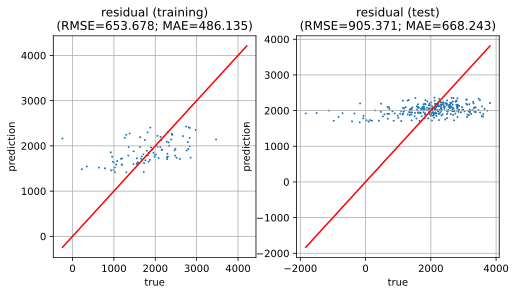

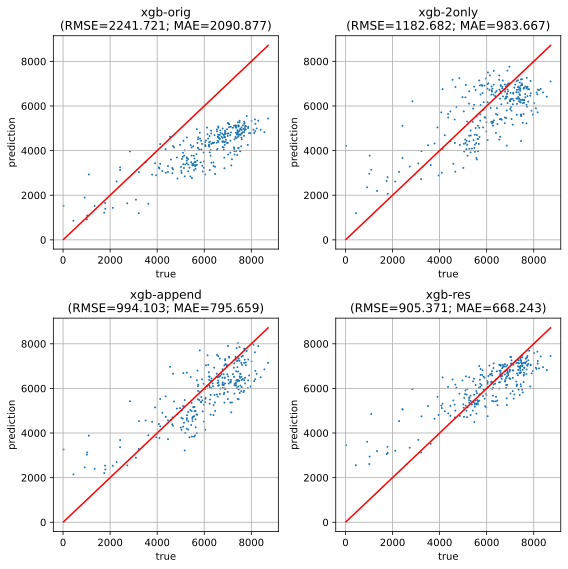

In [66]:
### INSERT YOUR CODE HERE

# select the XGB regressor
allexps_new = [dict(allexps[-1])]
basename = allexps_new[0]['name']

clfs_new = {}
trainerr_new = {}
testerr_new = {}

# train with original data (1st year)
allexps_new[0]['name'] = basename + '-orig'
train_all(clfs_new, allexps_new, trainX, trainY, testX2, testY2, trainerr_new, testerr_new)

# train with original+new training data
allexps_new[0]['name'] = basename + '-append'
train_all(clfs_new, allexps_new, trainX2_append, trainY2_append, testX2, testY2, trainerr_new, testerr_new)

# train with only new data
allexps_new[0]['name'] = basename + '-2only'
train_all(clfs_new, allexps_new, trainX2, trainY2, testX2, testY2, trainerr_new, testerr_new)

# train residual model
# use the original classifier to predict on new training data and new testing data
ptrainY2 = clfs_new[basename+'-orig'].predict(trainX2)
ptestY2  = clfs_new[basename+'-orig'].predict(testX2)
# training residual
rtrainY2 = trainY2-ptrainY2
# test residual
rtestY2 = testY2-ptestY2

# train the residual regressor
res_model = GaussianProcessRegressor(normalize_y=True, random_state=5489, kernel=RBF()+WhiteKernel())
res_model.fit(trainX2, rtrainY2)
# predict the residuals
res_predtrainY2 = res_model.predict(trainX2)
res_predtestY2 = res_model.predict(testX2)
# add the residual to make the new prediction
new_predtrainY2 = ptrainY2 + res_predtrainY2
new_predtestY2  = ptestY2  + res_predtestY2 
# evaluate
trainerr_new[basename+'-res'] = eval_predict(trainY2, new_predtrainY2)
testerr_new[basename+'-res']  = eval_predict(testY2,  new_predtestY2)

# plot residual predictions
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_scatter(rtrainY2, res_predtrainY2, 'residual (training)')
plt.subplot(1,2,2)
plot_scatter(rtestY2, res_predtestY2, 'residual (test)')

# plot test predictions
plt.figure(figsize=(8,8))
for i,n in enumerate(['-orig', '-2only', '-append']):
    plt.subplot(2,2,1+i)
    plot_scatter(testY2, clfs_new[basename+n].predict(testX2), basename+n)
plt.subplot(2,2,4)
plot_scatter(testY2, new_predtestY2, basename+'-res')
plt.tight_layout()

testerr_new

_Which approach for using the new data is better? Explain why you think the other approaches don't work well._
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
      - appending the new data doens't work well, compared to only using the new data. This is because the bias in the data confuses the regressor.
      - learning the residual works the best.  This is because it can learn a more complex function based on the residual differences to model the bias in the 2nd year.